<a href="https://colab.research.google.com/github/jonkrohn/DLTFpT/blob/master/notebooks/dense_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Activity Classifier

In this notebook, we build an LSTM neural net to classify PE activity.

#### Load dependencies

In [12]:
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import Bidirectional, LeakyReLU, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint 
import os 
from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # new!

#### Set hyperparameters

In [113]:
# output directory name:
output_dir = 'model_output/lstm1'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency

# LSTM layer architecture:
n_lstm_1 = 64 # lower
n_lstm_2 = 64 # new!
n_lstm_3 = 64
drop_lstm_1 = 0.05
drop_lstm_2 = 0.05
drop_lstm_3 = 0.05


# dense layer architecture: 
n_dense_1 = 256
dropout_1 = 0.2
n_dense_2 = 256
dropout_2 = 0.2
n_dense_3 = 128
dropout_3 = 0.2

# training:
epochs = 60
batch_size = 256


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [114]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [115]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [116]:
# change from string to integer so keras.to_categorical can consume it

# could do with factorize method as well
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)
labels_array_int

# check if the result is consistant with the original input
class_list[labels_array_int].reshape(len(labels_array_int), 1) == labels_array

# Note: to get the reverse, i.e converting integer array to string use class_list[labels_array_int]

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [117]:
# labels to categorical

y = to_categorical(labels_array_int, num_classes=n_class)
y.shape

(64754, 6)

In [118]:
input_shape = list(accel_array.shape)
input_shape

[64754, 90, 3]


#### Design neural network architecture

In [119]:
model = Sequential()
# model.add(Flatten(input_shape=input_shape[1:]))
model.add(LSTM(n_lstm_1, dropout=drop_lstm_1, 
                             return_sequences=True, input_shape=input_shape[1:])) 
model.add(LSTM(n_lstm_2, dropout=drop_lstm_2, 
                             return_sequences=True))
model.add(LSTM(n_lstm_3, dropout=drop_lstm_3, 
                             return_sequences=True)) 
# model.add(Bidirectional(LSTM(n_lstm_2, dropout=drop_lstm_2)))
# model.add(GlobalMaxPooling1D())
# model.add(GlobalAveragePooling1D())
model.add(Flatten())
model.add(Dense(n_dense_1, activation=LeakyReLU(alpha=0.1)))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation='relu'))
model.add(Dropout(dropout_2))
model.add(Dense(n_dense_3, activation=LeakyReLU(alpha=0.1)))
model.add(Dropout(dropout_3))
model.add(Dense(n_class, activation='softmax'))
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 90, 64)            17408     
_________________________________________________________________
lstm_37 (LSTM)               (None, 90, 64)            33024     
_________________________________________________________________
lstm_38 (LSTM)               (None, 90, 64)            33024     
_________________________________________________________________
flatten_10 (Flatten)         (None, 5760)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 256)               1474816   
_________________________________________________________________
dropout_39 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 256)             

### Splitting and shuffeling the data

In [120]:
# split and shuffle
x_train, x_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)

#### Configure model

In [121]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [122]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [123]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [124]:
model.fit(x_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(x_valid, y_valid), 
         callbacks=[modelcheckpoint])

Epoch 1/60
228/228 [==============================] - 8s 36ms/step - loss: 1.2854 - accuracy: 0.4481 - val_loss: 0.9678 - val_accuracy: 0.5976
Epoch 2/60
228/228 [==============================] - 7s 31ms/step - loss: 0.9448 - accuracy: 0.5892 - val_loss: 0.7768 - val_accuracy: 0.6688
Epoch 3/60
228/228 [==============================] - 7s 31ms/step - loss: 0.7795 - accuracy: 0.6671 - val_loss: 0.7123 - val_accuracy: 0.6961
Epoch 4/60
228/228 [==============================] - 7s 31ms/step - loss: 0.6569 - accuracy: 0.7268 - val_loss: 0.5552 - val_accuracy: 0.7861
Epoch 5/60
228/228 [==============================] - 7s 31ms/step - loss: 0.5708 - accuracy: 0.7705 - val_loss: 0.4596 - val_accuracy: 0.8184
Epoch 6/60
228/228 [==============================] - 7s 31ms/step - loss: 0.5038 - accuracy: 0.8013 - val_loss: 0.4125 - val_accuracy: 0.8396
Epoch 7/60
228/228 [==============================] - 7s 31ms/step - loss: 0.4544 - accuracy: 0.8214 - val_loss: 0.3742 - val_accuracy: 0.8590

Epoch 58/60
228/228 [==============================] - 7s 32ms/step - loss: 0.1468 - accuracy: 0.9431 - val_loss: 0.2644 - val_accuracy: 0.9219
Epoch 59/60
228/228 [==============================] - 7s 32ms/step - loss: 0.1438 - accuracy: 0.9436 - val_loss: 0.2628 - val_accuracy: 0.9172
Epoch 60/60
228/228 [==============================] - 7s 32ms/step - loss: 0.1398 - accuracy: 0.9453 - val_loss: 0.2376 - val_accuracy: 0.9361


#### Evaluate

In [125]:
model.load_weights(output_dir+"/weights.60.hdf5") # 93.61 val accuracy

In [126]:
y_hat = model.predict(x_valid)

In [127]:
len(y_hat)

6476

In [128]:
y_hat[0]

array([3.3374137e-04, 6.5218779e-07, 2.9682074e-06, 4.7973078e-08,
       5.7489134e-04, 9.9908769e-01], dtype=float32)

In [129]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

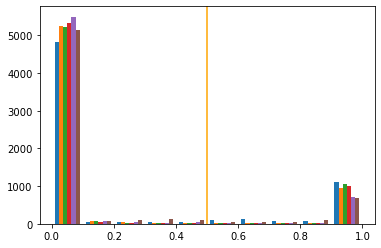

In [130]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [131]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [132]:
"{:0.2f}".format(pct_auc)

'99.47'

In [139]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [140]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [141]:
ydf.head(10)

,y_hat,y
0,"[0.0, 0.0, 0.0, 0.0, 0.001, 0.999]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.256, 0.002, 0.0, 0.0, 0.002, 0.74]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.043, 0.826, 0.012, 0.012, 0.098, 0.01]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
